# Robot target kalibratie

> Tot hiertoe kunnen we dus punten (objecten) gezien door de camera omzetten van camera coördinaten naar baselink coördinaten met de transformatiematrix ${}^{B}T_{C}$. Nu rest er ons enkel nog een object te detecteren met de camera. De camera kan namelijk RBG beelden uitlezen maar om effectief objecten te herkennen is er meer nodig. Eens we een object kunnen herkennen uit RGB beelden of uit pointclouds (3D beelden gebruik makende van dieptes die speciale dieptecamera's kunnen uitlezen), kunnen we de positie van dit object bepalen in camera frame en dit dan omzetten naar baselink frame. Het detecteren van objecten kan op verschillende manieren gebeuren. Maar hier gaan we er voorlopig vanuit dat een object beschreven is in een referentieframe dat we terug voorstellen met een dambordpatroon en dat we leggen in het robot veld.



# 1. Importeer bibliotheken

Deze bibliotheken zijn nodig voor het volbrengen van dit script. In de CameraCalibration bibliotheek (die je vindt in de Classes folder op je Google Drive) vind je de code achter de commando's die je hier zal gebruiken.  

In [2]:
import sys
sys.path.append('/content/drive/My Drive/object_pose_estimation_online')
from Classes.CameraCalibration import *
from google.colab.patches import cv2_imshow

# 2. Importeer alle beelden voor robot-target kalibratie

> Alle afbeeldingen bevinden zich onder de map /content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images. Als je dit uitprint kan je zien dat dit een array is met alle 10 de padnamen naar elke afbeelding. 

In [3]:
# Find all image paths
robot_target_calibration_images_file = '/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_*.jpg'
images_path_names = get_image_path_names(robot_target_calibration_images_file)
print(images_path_names)

['/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_1.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_2.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_3.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_4.jpg', '/content/drive/My Drive/object_pose_estimation_online/data/robot_target_calibration_images/RTC_image_original_5.jpg']


> We kunnen terug kijken hoe een dergelijke afbeelding eruit ziet. Merk op dat het dambordpatroon deze keer in het robot veld ligt. Als we het object (doosje ernaast) voorlopig op een gekende plaats in dat frame leggen en we de positie van het target frame in het baselinkframe kunnen bepalen, dan kent de robot dus de positie van het object ten opzichte van zichzelf en kan het het object gaan grijpen. 

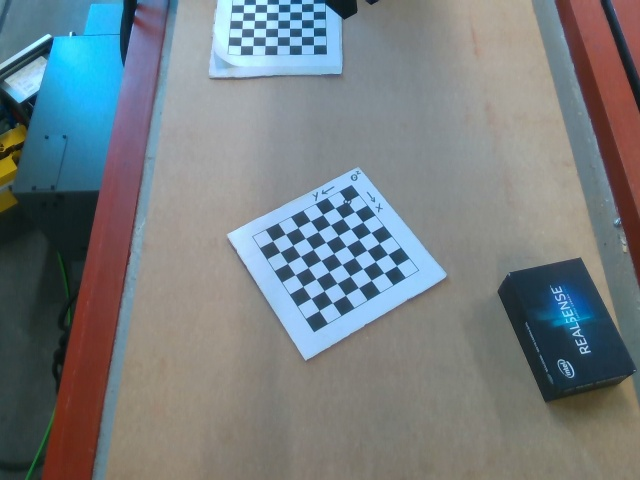

In [4]:
# Preview image
image_path = images_path_names[0]
image = read_image(image_path)
cv2_imshow(image)

# 3. Load baselink-camera transformation matrix

Hier laden we de baselink-camera matrix die we in vorig script berekend hebben. 

In [6]:
# Import baselink-camera transformation matrix (numpy data)
mean_baselink_camera_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_camera_transformation.npy'
bc_transform = get_numpy_data(mean_baselink_camera_transformation_file)
print("Baselink-camera transform: \n\n" + str(bc_transform))

Baselink-camera transform: 

[[ 0.99386435  0.08581828 -0.06977735 -0.02585932]
 [ 0.10647747 -0.9130998   0.39358774 -1.06063782]
 [-0.02993666 -0.39860253 -0.91663505  0.75004694]
 [ 0.          0.          0.          1.        ]]


> Deze matrix stelt dus de transformatiematrix voor van baselink frame {B} naar het cameraframe {C}, ${}^{B}T_{C}$. Of in andere woorden, deze matrix kan punten beschreven in het camera frame omzetten in het baselink frame. 

$$ {}^{B}P = {}^{B}T_{T}*{}^{T}P$$

> Merk op dat de getallen in de laatste kolom van boven naar beneden de x-, y-, en z-positie weergeven van het camera frame ten opzichte van het baselink frame.

# 4. Laden van de berekende intrinsieke camera matrix

> In vorige opgave heb je de intrinsieke matrix opgelsagen, deze werd automatisch opgeslagen onder /content/drive/My Drive/object_pose_estimation_online/data/matrix_files/intrinsic_camera_properties.npz. Deze kunnen we nu laden. De functie "load_intrinsic_camera_matrix" geeft je niet enkel de intrinsieke matrix, maar ook de distrotiecoëfficiënten nodig voor de kalibratie.

In [14]:
# Load intrinsic camera matrix and distortion coefficients
intrinsic_camera_matrix_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files//intrinsic_camera_properties.npz'
mtx, dist = load_intrinsic_camera_matrix(intrinsic_camera_matrix_file)

# 5. Robot-target calibration

Hier gaan we dus nog eens een extrinsieke kalibratie uitvoeren om de positie van het target frame, gelegen in het robot veld, te kennen in het camera frame. Weer worden de metrische coördinaten van het dambordpatroon bekomen, een beeld ingelezen, omgezet naar grayscale, hoeken berekend, en deze info aan het kalibratiealgoritme gegeven. 

In [15]:
# Prepare object points in 3D space in meters
objp = get_object_points()

In [16]:
# Read image
image = read_image(image_path)

In [17]:
# Turn image to grayscale
gray = image_to_grayscale(image)

In [18]:
# Find the corners in the chessbord calibration tool
corners = find_corners(gray)

In [20]:
# Get extrinsic camera calibration matrix (target - camera transform)
ct_transform = extrinsic_calibration(objp, corners, mtx, dist)
print("Camera-target transform: \n\n" + str(ct_transform))

Camera-target transform: 

[[ 0.4907859  -0.86690691  0.08718724  0.10919248]
 [ 0.734085    0.46532988  0.49455769 -0.05527263]
 [-0.46930631 -0.1787191   0.8647607   0.87938069]
 [ 0.          0.          0.          1.        ]]


In [21]:
# Get baselink - target transform
bt_transform = multiply_transforms(bc_transform, ct_transform)

In [22]:
# Save the mean baselink - target transformation matrix
baselink_target_transformation_file = '/content/drive/My Drive/object_pose_estimation_online/data/matrix_files/mean_baselink_target_transformation'
save_to_numpy(baselink_target_transformation_file, bt_transform)

In [23]:
print("Baselink-camera transform: \n\n" + str(bt_transform))

Baselink-camera transform: 

[[ 0.58351947 -0.80918351  0.06875367  0.01655894]
 [-0.80274843 -0.58754032 -0.10193785 -0.6524284 ]
 [ 0.12288198  0.00429082 -0.99241202 -0.03726128]
 [ 0.          0.          0.          1.        ]]




> Deze matrix geeft dus de positie van het targetframe in baselink frame. Als we in dit frame een object definiëren op een gekende positie in het target frame, kunnen we dit object dus kennen in het baselink frame en grijpen met de robot. 

